# Final Project - Group 32

# Group members names

Please write names below

* Jiarui Zhao
* Xian Lou
* Yuwen Xia
* Hengyuan Zhang
* Yuhao Yang

## Preparation before our work

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
#%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 9)
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

Populating the interactive namespace from numpy and matplotlib


## Our Basic Idea:

Our team intend to construct the optimal portfolio using the method which can give us the highest Sharpe Ratio. 
The basic idea is to firstly construct the separate optimal portfolios in terms of 3 factors we choose and then construct the final optimal portfolio using the three previous seperate constructed optimal portfolio.

## Step1. Choose the factors (three)
Here are the factors that we want to choose:
* Market---MKT (market)
* Size---SMB (Long small-cap stocks and short large-cap stocks)
* Value---HML (Long value-stocks and short growth-stocks)

The factors data we used is the daily return from 9/30/2010 to 8/30/2019 for several factors, which is stored in this website: 

https://www.dropbox.com/s/rl9agxu8i8brdw8/factor.csv?dl=0

In [2]:
#input data of factors
factors = pd.read_csv('https://www.dropbox.com/s/rl9agxu8i8brdw8/factor.csv?dl=1', parse_dates = ['DATE'])
factors.set_index('DATE', inplace = True)
factors=factors/100
factors.tail()

,MKTRF,SMB,HML,RF
DATE,,,,
2019-08-26,0.0108,-0.0002,-0.0021,0.00007
2019-08-27,-0.0046,-0.0087,-0.0068,0.00007
2019-08-28,0.0068,0.0047,0.0062,0.00007
2019-08-29,0.0135,0.0031,0.0034,0.00007
2019-08-30,0.0003,-0.0038,0.0026,0.00007


## Step2. Cast a wide to find ETFs that attempt to implement these factors 

We choose the MKT ETF data from ETFdb.com and select the top ten ETFs in the U.S. ETF List. Then we search these ETFs on Yahoo Financial and get the daily prices data from 9/30/2010 to 8/30/2019. Next, we use these datas to calculate the daily returns of these 10 ETFs.
The webside of the U.S. ETF List and the webside we store the daily returns of these 10 ETFs are as follow:

The U.S. ETF List: https://etfdb.com/etfs/country/us/

We store the daily returns of these 10 ETFs: https://www.dropbox.com/s/vep8x5yjzhufx17/lastest%20version%20MKT.csv?dl=0

In [3]:
#ETF-MKT
MKT = pd.read_csv('https://www.dropbox.com/s/vep8x5yjzhufx17/lastest%20version%20MKT.csv?dl=1', parse_dates = ['DATE'])
MKT.set_index('DATE', inplace= True)
MKT.head()

,SPY,IVV,VTI,VOO,QQQ,BND,IJH,IWF,VTV,AGG
DATE,,,,,,,,,,
2010-09-30,-0.002980,-0.002971,-0.002232,-0.001541,-0.004473,-0.000494,0.001240,-0.004274,-0.001445,-0.000378
2010-10-01,0.004196,0.004445,0.004444,0.003440,-0.001233,-0.003518,0.002363,0.003494,0.006355,-0.003600
2010-10-04,-0.007514,-0.007488,-0.008879,-0.008413,-0.010824,0.002539,-0.011347,-0.008351,-0.006743,0.001653
2010-10-05,0.020122,0.019703,0.020813,0.021947,0.024330,0.000232,0.020907,0.019747,0.019916,-0.000010
2010-10-06,-0.000096,0.000162,-0.001021,-0.001706,-0.008669,0.002290,-0.006675,-0.001353,0.000997,0.001004


We choose the SMB ETF data from ETFdb.com and select the nine ETFs in the Small-Cap ETF List based on the limits of the same time period and the
nature of the ETF focusing on the blend of the value and growth investment. Then we search these ETFs on Yahoo Finance and get the daily prices from
9/30/2010 to 8/30/2019. Next, we use these datas to calculate the daily returns of these 9 ETFs.The webside of the Small-Cap ETF List and the webside we store the daily return of these 9 ETFs are:

The Small-Cap ETF List: https://etfdb.com/etfs/size/small-cap/
    
We store the daily return of these 9 ETFs:https://www.dropbox.com/s/er14caqop4jx0y8/SMB.csv?dl=0

In [4]:
#ETF-SMB
SMB = pd.read_csv('https://www.dropbox.com/s/er14caqop4jx0y8/SMB.csv?dl=1', parse_dates = ['DATE'])
SMB.set_index('DATE', inplace= True)
SMB.head()

,SCHA,JKJ,SLY,IWM,GDXJ,SCIF,VB,SCHC,VSS
DATE,,,,,,,,,
2010-09-30,-0.002024,-0.001813,-0.000695,-0.002512,-0.019665,-0.006002,-0.001574,-0.002634,-0.003152
2010-10-01,0.005409,0.004930,-0.002436,0.005333,0.023653,0.036228,0.004729,0.011316,0.013956
2010-10-04,-0.012777,-0.011748,-0.006976,-0.013557,-0.024861,-0.003586,-0.012237,-0.009698,-0.010323
2010-10-05,0.025545,0.024559,0.026695,0.028384,0.039592,0.030589,0.024301,0.022599,0.021512
2010-10-06,-0.005314,-0.003443,-0.008553,-0.003341,0.021639,-0.001309,-0.003566,0.004420,0.005637


We choose the HML ETF data from Yahoo Finance and select the top ten ETFs in the Top-Ranked Value ETFs for the Current Market based on the limit of the same time period. Then we search these ETFs on Yahoo Finance and get the daily prices from 9/30/2010 to 8/30/2019. Next, we use these datas to calculate the daily returns of these 10 ETFs.The webside of the ETF List and the webside we store the daily return of these 10 ETFs are:

The ETF List: https://finance.yahoo.com/news/spread-top-ranked-value-etfs-142502441.html
    
We store the daily return of these 10 ETFs: https://www.dropbox.com/s/e4w510rtrqp3v2i/10%20NEW%20VALUE.csv?dl=0

In [5]:
#ETF-HML
HML = pd.read_csv('https://www.dropbox.com/s/e4w510rtrqp3v2i/10%20NEW%20VALUE.csv?dl=1', parse_dates = ['DATE'])
HML.set_index('DATE', inplace= True)
HML.head()

,DIA,IWD,MDYV,MGV,PRFDX,RFV,RZV,VOE,VONV,VTV
DATE,,,,,,,,,,
2010-10-01,0.003799,0.006103,0.000603,0.007910,0.005594,0.001004,0.006456,0.004128,0.002929,0.006365
2010-10-04,-0.006924,-0.006908,-0.009849,-0.008408,-0.008809,-0.012701,-0.012523,-0.007194,-0.007593,-0.006733
2010-10-05,0.017012,0.019511,0.020706,0.022046,0.021048,0.022343,0.030622,0.021118,0.023151,0.019926
2010-10-06,0.003382,0.001165,-0.004375,0.000276,0.000000,-0.002318,0.004802,-0.003650,-0.002876,0.001007
2010-10-07,-0.001549,-0.001828,0.000200,0.000553,-0.002749,-0.001659,0.001792,0.000610,-0.000385,-0.000805


We define a linear regression function as follow.

In [6]:
from scipy.stats import chi2
def Time_Series_Regressions(portfolios, factors, ptf_list, beg, end):
    portfolios.iloc[:,:-1] = portfolios.iloc[:,:-1].subtract(factors['RF'], axis = 'index')
    df = pd.merge(portfolios, factors, left_index = True, right_index = True)
    df = df[beg:end] 
    E = pd.DataFrame(df[ptf_list].mean()*252, columns = ['AvgReturns'])
    E['Std'] = df[ptf_list].std()*252**.5
    E['Alpha'] = E['AvgReturns']*np.nan
    E['t_Alpha'] = E['AvgReturns']*np.nan
    E['b_MKTRF'] = E['AvgReturns']*np.nan
    E['t_MKTRF'] = E['AvgReturns']*np.nan
    E['b_SMB'] = E['AvgReturns']*np.nan
    E['t_SMB'] = E['AvgReturns']*np.nan
    E['b_HML'] = E['AvgReturns']*np.nan
    E['t_HML'] = E['AvgReturns']*np.nan
    
    T = df.shape[0]
    muF = df[['MKTRF','SMB','HML']].mean()
    invCovF = np.linalg.inv(df[['MKTRF','SMB','HML']].cov())
    Resid = pd.DataFrame([], index = df.index, columns = ptf_list)
    x = sm.add_constant(df[['MKTRF','SMB','HML']])
    for ptf in ptf_list:
        y = df[ptf]
        res = sm.OLS(y,x,missing="drop").fit()
        E.loc[ptf,'Alpha'] = res.params[0]*252
        E.loc[ptf,'b_MKTRF'] = res.params[1]
        E.loc[ptf,'b_SMB'] = res.params[2]
        E.loc[ptf,'b_HML'] = res.params[3]
        E.loc[ptf,'t_Alpha'] = res.tvalues[0]
        E.loc[ptf,'t_MKTRF'] = res.tvalues[1]
        E.loc[ptf,'t_SMB'] = res.tvalues[2]
        E.loc[ptf,'t_HML'] = res.tvalues[3]
        E.loc[ptf,'R_Squared'] = res.rsquared
        Resid.loc[:,ptf] = res.resid # this is for GRS
    E['SR'] = E['AvgReturns']/E['Std']
    E['AR'] = 252**.5*E['t_Alpha']/T**.5  
    # GRS test
    invCov = np.linalg.inv(Resid.cov())
    chi = T*(1+(muF.values @ invCovF @ muF.values.T))**(-1)*(E.Alpha.values @invCov@ E.Alpha.values.T)
    N = Resid.shape[1]   
    return E, [chi,(1-chi2.cdf(chi,N))*100]

## Firstly, we talk about the Market factor (MKT ETFs)

## Step3. Organize a data set on the returns of the MKT ETFs

We run linear regression on market factor(MKT ETFs).

In [7]:
ptfs = MKT.copy()
RESULTS_MKT, GRS = Time_Series_Regressions(MKT, factors, MKT.columns, '2010', '2019')
RESULTS_MKT

,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
SPY,0.105808,0.144405,-0.025359,-5.416471,0.986071,474.146134,-0.142847,-37.200255,-0.002951,-0.773086,0.990691,0.732717,-1.814715
IVV,0.106222,0.144888,-0.025311,-5.121844,0.988678,450.401061,-0.141582,-34.931889,-0.004272,-1.060508,0.989698,0.733134,-1.716005
VTI,0.105909,0.147231,-0.024000,-5.440919,0.988176,504.322748,-0.022135,-6.118118,0.000040,0.011095,0.992051,0.719343,-1.822906
VOO,0.106431,0.144165,-0.024303,-4.926678,0.983145,448.671588,-0.136488,-33.734660,-0.003874,-0.963304,0.989631,0.738257,-1.650617
QQQ,0.154717,0.171144,-0.006373,-0.384466,1.092757,148.404008,-0.143079,-10.523686,-0.546665,-40.453931,0.916921,0.904012,-0.128810
BND,-0.006173,0.033629,-0.000630,-0.059965,-0.064337,-13.786533,-0.011531,-1.338237,-0.094239,-11.003899,0.135731,-0.183557,-0.020090
IJH,0.099669,0.164523,-0.019760,-1.604760,0.983107,179.742292,0.413404,40.934864,0.157097,15.650729,0.950397,0.605807,-0.537653
IWF,0.128612,0.151695,-0.015381,-2.469777,1.017082,367.653303,-0.099799,-19.537946,-0.319597,-62.950970,0.985074,0.847832,-0.827465
VTV,0.090087,0.142964,-0.028565,-3.597141,0.952160,269.929669,-0.140000,-21.495053,0.271287,41.906948,0.972677,0.630142,-1.205173
AGG,0.001060,0.033233,0.005513,0.522669,-0.054585,-11.650993,-0.009085,-1.050272,-0.088762,-10.323641,0.108021,0.031882,0.175113


We show the performance of these ETFs during the selected time period.

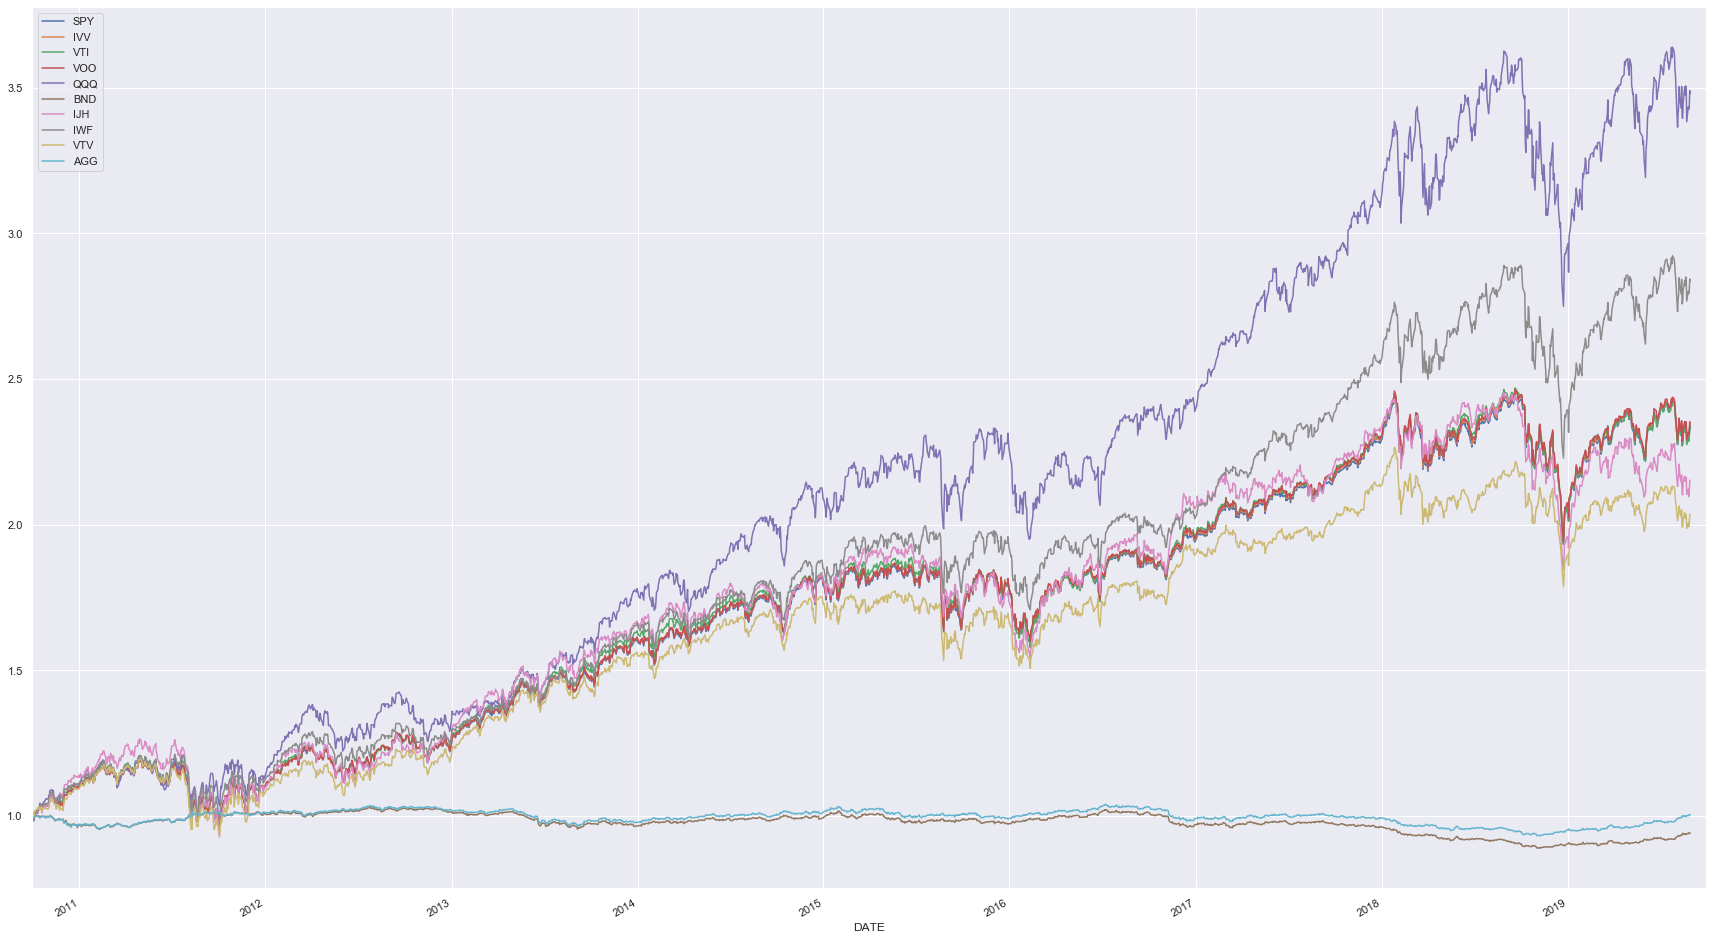

In [8]:
graph_MKT = (1+MKT).cumprod().plot(figsize = (30,18));
graph_MKT.set_xlim([datetime.date(2010, 9, 30), datetime.date(2019, 9, 30)]);

## Step4. Factor by factor look at how well the MKT ETFs implement the factors
## a. Focus on how well the ETF span exposure to the factor

The larger the beta is, the better the ETFs implement the factors

## b. And how cheaply it does, i.e., per unit of exposure to the factor, how much investors pay in terms of a negative alpha, and in terms of tracking error

In [9]:
cost_MKT=RESULTS_MKT['Alpha']
cost_MKT.sort_values()

VTV   -0.028565
SPY   -0.025359
IVV   -0.025311
VOO   -0.024303
VTI   -0.024000
IJH   -0.019760
IWF   -0.015381
QQQ   -0.006373
BND   -0.000630
AGG    0.005513
Name: Alpha, dtype: float64

We analyse this question using the negative Alpha. We sort the Alpha of each ETF. The smaller the value is, the more the investors pay and the more expensive the ETF is.

## Step5. Come up with a way to rank these ETFs for each factor and explain your thinking behind the ranking

Part(1) We rank these ETFs based on the condition of R_Squared>0.7 and Sharpe Ratio>0 and sort them based on b_MKTRF.

In [10]:
RESULTS_MKT_RANK=RESULTS_MKT[(RESULTS_MKT.R_Squared>0.7) & (RESULTS_MKT.SR>0)]
RESULTS_MKT_RANK.sort_values('b_MKTRF',inplace=True)
RESULTS_MKT_RANK

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
VTV,0.090087,0.142964,-0.028565,-3.597141,0.952160,269.929669,-0.140000,-21.495053,0.271287,41.906948,0.972677,0.630142,-1.205173
IJH,0.099669,0.164523,-0.019760,-1.604760,0.983107,179.742292,0.413404,40.934864,0.157097,15.650729,0.950397,0.605807,-0.537653
VOO,0.106431,0.144165,-0.024303,-4.926678,0.983145,448.671588,-0.136488,-33.734660,-0.003874,-0.963304,0.989631,0.738257,-1.650617
SPY,0.105808,0.144405,-0.025359,-5.416471,0.986071,474.146134,-0.142847,-37.200255,-0.002951,-0.773086,0.990691,0.732717,-1.814715
VTI,0.105909,0.147231,-0.024000,-5.440919,0.988176,504.322748,-0.022135,-6.118118,0.000040,0.011095,0.992051,0.719343,-1.822906
IVV,0.106222,0.144888,-0.025311,-5.121844,0.988678,450.401061,-0.141582,-34.931889,-0.004272,-1.060508,0.989698,0.733134,-1.716005
IWF,0.128612,0.151695,-0.015381,-2.469777,1.017082,367.653303,-0.099799,-19.537946,-0.319597,-62.950970,0.985074,0.847832,-0.827465
QQQ,0.154717,0.171144,-0.006373,-0.384466,1.092757,148.404008,-0.143079,-10.523686,-0.546665,-40.453931,0.916921,0.904012,-0.128810


Part(2) We select 3 target ETFs based on b_MKTRF (from top to bottom).

In [11]:
MKT_TARGET=MKT[['QQQ','IWF','IVV']]
MKT_TARGET.head()

,QQQ,IWF,IVV
DATE,,,
2010-09-30,-0.004483,-0.004284,-0.002981
2010-10-01,-0.001243,0.003484,0.004435
2010-10-04,-0.010834,-0.008361,-0.007498
2010-10-05,0.024320,0.019737,0.019693
2010-10-06,-0.008679,-0.001363,0.000152


## Step6. Once you have the top ranked ETF for each of your factors, explain how to construct the optimal portfolio among these ETFs. Explain your logic.

We construct these ETFs using 3 different weighting method.

Equal weighted

In [12]:
RF=factors['RF'].mean()*252

In [13]:
EW=np.ones(3)/3
RE_MKT_EW=(MKT_TARGET@EW).mean()*252

STD_MKT_EW=(EW.T@MKT_TARGET.cov()@EW*252)**0.5

SR_MKT_EW=(RE_MKT_EW-RF)/STD_MKT_EW
SR_MKT_EW
print("The SR of Equal weighted is",SR_MKT_EW)

The SR of Equal weighted is 0.8138419570569039


Mean-variance efficient

In [14]:
MKT_TARGET_Mean = MKT_TARGET.mean()
MKT_TARGET_Std = MKT_TARGET.std()
MKT_TARGET_Cov = MKT_TARGET.cov()
MKT_TARGET_W = pd.DataFrame([], index = MKT_TARGET.columns)
MKT_TARGET_W['MKT_MVE'] = np.linalg.inv(MKT_TARGET_Cov)@ MKT_TARGET_Mean
MKT_TARGET_W['MKT_MVE'] = MKT_TARGET_W['MKT_MVE']/MKT_TARGET_W['MKT_MVE'].sum()
MKT_TARGET_W['MKT_MVE']

QQQ    0.925115
IWF    2.782237
IVV   -2.707351
Name: MKT_MVE, dtype: float64

In [15]:
MKT_W_MVE=MKT_TARGET_W['MKT_MVE']
RE_MKT_MVE=(MKT_TARGET@MKT_W_MVE).mean()*252

STD_MKT_MVE=(MKT_W_MVE.T@MKT_TARGET.cov()@MKT_W_MVE*252)**0.5

SR_MKT_MVE=(RE_MKT_MVE-RF)/STD_MKT_MVE
SR_MKT_MVE
print("The SR of Mean-variance efficient is",SR_MKT_MVE)

The SR of Mean-variance efficient is 0.9492458633309256


Minimun Variance

In [16]:
MKT_TARGET_W['MKT_MV'] = np.linalg.inv(MKT_TARGET_Cov)@ np.ones(MKT_TARGET_Mean.shape[0])
MKT_TARGET_W['MKT_MV'] = MKT_TARGET_W['MKT_MV']/MKT_TARGET_W['MKT_MV'].sum()
MKT_TARGET_W['MKT_MV']

QQQ   -0.568665
IWF    0.478284
IVV    1.090381
Name: MKT_MV, dtype: float64

In [17]:
MKT_W_MV=MKT_TARGET_W['MKT_MV']
RE_MKT_MV=(MKT_TARGET@MKT_W_MV).mean()*252

STD_MKT_MV=(MKT_W_MV.T@MKT_TARGET.cov()@MKT_W_MV*252)**0.5

SR_MKT_MV=(RE_MKT_MV-RF)/STD_MKT_MV
SR_MKT_MV
print("The SR of Minimun Variance is",SR_MKT_MV)

The SR of Minimun Variance is 0.593915322688077


We plot the Sharpe ratios of different allocation methods.

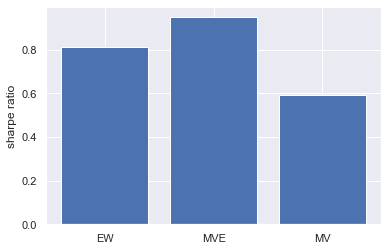

In [18]:
names=['EW','MVE','MV']
values=[SR_MKT_EW,SR_MKT_MVE,SR_MKT_MV]
plt.figure(figsize(6,4))
plt.bar(names,values)
plt.ylabel('sharpe ratio');

From the above graph, we found that the Mean-variance efficient method can give us the highest Sharpe Ratio, thus we choose this method to construct our final optimal portfolio.
We show the optimal weight using bar chart.

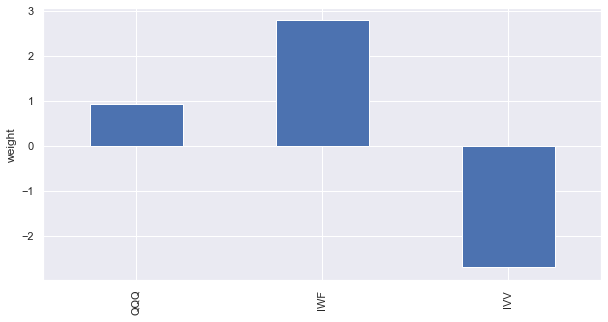

In [19]:
MKT_TARGET_W['MKT_MVE'].plot(kind='bar',figsize=(10,5))
plt.ylabel('weight');

Apparently, we choose the MVE method because it has the highest SR.

## Secondly, we talk about the Size factor (SMB ETFs)

## Step3. Organize a data set on the returns of the SMB ETFs

We run linear regression on size factor.

In [20]:
RESULTS_SMB, GRS = Time_Series_Regressions(SMB, factors, SMB.columns, '2010', '2019')
RESULTS_SMB

,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
SCHA,0.106145,0.178116,-0.013786,-1.819805,1.009327,299.937816,0.705589,113.558779,0.137901,22.329821,0.983980,0.595931,-0.609701
JKJ,0.098984,0.175906,-0.011497,-0.664866,0.961241,125.138759,0.653026,46.042589,0.266651,18.915565,0.914419,0.562712,-0.222754
SLY,0.103019,0.178791,-0.004918,-0.274051,0.937379,117.581749,0.784329,53.283491,0.192941,13.187617,0.910768,0.576197,-0.091817
IWM,0.101022,0.186950,-0.018747,-2.617145,1.021491,321.028424,0.856605,145.800472,0.136154,23.316092,0.986999,0.540370,-0.876839
GDXJ,-0.036204,0.454746,-0.084857,-0.565958,0.456984,6.861443,0.455672,3.705412,0.199539,1.632522,0.037295,-0.079613,-0.189616
SCIF,-0.076855,0.291188,-0.210867,-2.555957,1.053691,28.752680,-0.050888,-0.752051,0.165206,2.456451,0.289141,-0.263935,-0.856339
VB,0.108470,0.174962,-0.013493,-1.484109,1.011669,250.496696,0.616503,82.673956,0.115431,15.574072,0.976086,0.619965,-0.497231
SCHC,0.053191,0.160318,-0.061261,-2.136501,0.904455,71.011032,0.014054,0.597611,0.138008,5.904183,0.716719,0.331783,-0.715806
VSS,0.023167,0.163495,-0.094046,-3.232019,0.924706,71.541357,0.012983,0.543999,0.134866,5.685570,0.719491,0.141701,-1.082844


We show the performance of these ETFs in during the selected time period.

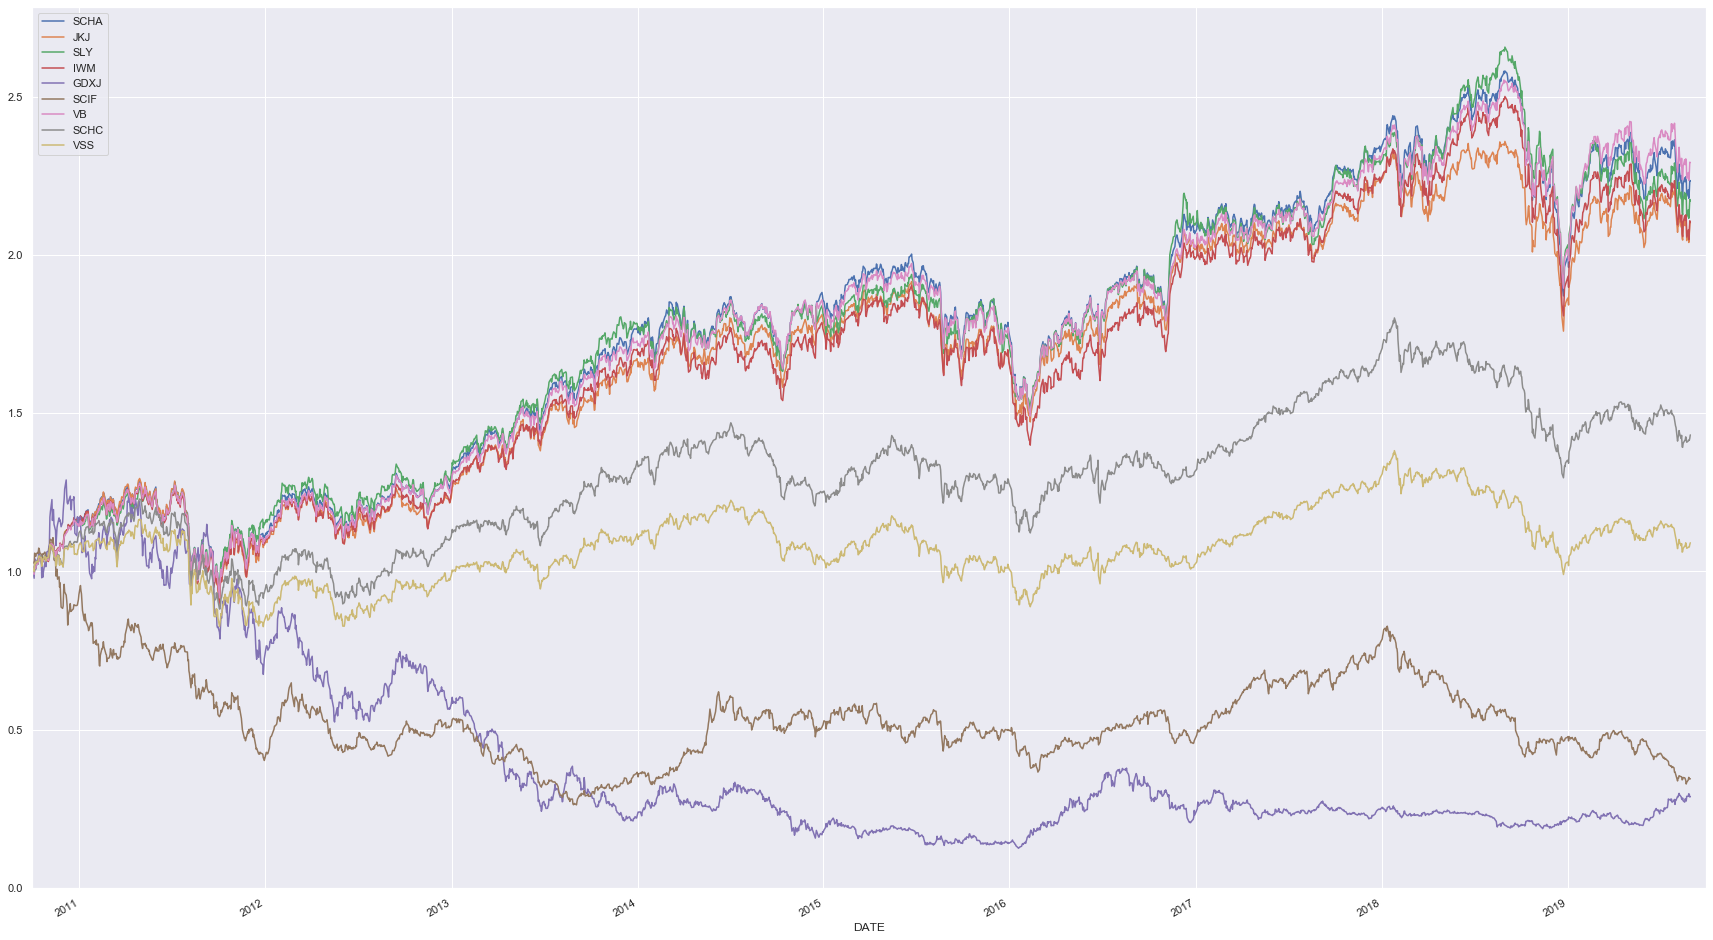

In [21]:
graph_SMB = (1+SMB).cumprod().plot(figsize = (30,18));
graph_SMB.set_xlim([datetime.date(2010, 9, 30), datetime.date(2019, 9, 30)]);

## Step4. Factor by factor look at how well the SMB ETFs implement the factors
## a. Focus on how well the ETF span exposure to the factor

The larger the beta is, the better the ETFs implement the factors

## b. And how cheaply it does, i.e., per unit of exposure to the factor, how much investors pay in terms of a negative alpha, and in terms of tracking error

In [22]:
cost_SMB=RESULTS_SMB['Alpha']
cost_SMB.sort_values()

SCIF   -0.210867
VSS    -0.094046
GDXJ   -0.084857
SCHC   -0.061261
IWM    -0.018747
SCHA   -0.013786
VB     -0.013493
JKJ    -0.011497
SLY    -0.004918
Name: Alpha, dtype: float64

We analyse this question using the negative Alpha. We sort the Alpha of each ETF. The smaller the value is, the more the investors pay and the more expensive the ETF is.

## Step5. Come up with a way to rank these ETFs for each factor and explain your thinking behind the ranking

Part(1) We rank these ETFs based on the condition of R_Squared>0.7 and Sharpe Ratio>0 and sort them based on b_SMB.

In [23]:
RESULTS_SMB_RANK=RESULTS_SMB[(RESULTS_SMB.R_Squared>0.7) & (RESULTS_SMB.SR>0)]
RESULTS_SMB_RANK.sort_values('b_SMB',inplace=True)
RESULTS_SMB_RANK

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
VSS,0.023167,0.163495,-0.094046,-3.232019,0.924706,71.541357,0.012983,0.543999,0.134866,5.685570,0.719491,0.141701,-1.082844
SCHC,0.053191,0.160318,-0.061261,-2.136501,0.904455,71.011032,0.014054,0.597611,0.138008,5.904183,0.716719,0.331783,-0.715806
VB,0.108470,0.174962,-0.013493,-1.484109,1.011669,250.496696,0.616503,82.673956,0.115431,15.574072,0.976086,0.619965,-0.497231
JKJ,0.098984,0.175906,-0.011497,-0.664866,0.961241,125.138759,0.653026,46.042589,0.266651,18.915565,0.914419,0.562712,-0.222754
SCHA,0.106145,0.178116,-0.013786,-1.819805,1.009327,299.937816,0.705589,113.558779,0.137901,22.329821,0.983980,0.595931,-0.609701
SLY,0.103019,0.178791,-0.004918,-0.274051,0.937379,117.581749,0.784329,53.283491,0.192941,13.187617,0.910768,0.576197,-0.091817
IWM,0.101022,0.186950,-0.018747,-2.617145,1.021491,321.028424,0.856605,145.800472,0.136154,23.316092,0.986999,0.540370,-0.876839


Part(2) We select 3 target ETFs based on b_SMB (from top to bottom).

In [24]:
SMB_TARGET=SMB[['IWM','SLY','SCHA']]
SMB_TARGET.head()

,IWM,SLY,SCHA
DATE,,,
2010-09-30,-0.002522,-0.000705,-0.002034
2010-10-01,0.005323,-0.002446,0.005399
2010-10-04,-0.013567,-0.006986,-0.012787
2010-10-05,0.028374,0.026685,0.025535
2010-10-06,-0.003351,-0.008563,-0.005324


## Step6. Once you have the top ranked ETF for each of your factors, explain how to construct the optimal portfolio among these ETFs. Explain your logic.

We construct these ETFs using 3 different weighting method.

Equal weighted

In [25]:
EW=np.ones(3)/3
RE_SMB_EW=(SMB_TARGET@EW).mean()*252

STD_SMB_EW=(EW.T@SMB_TARGET.cov()@EW*252)**0.5

SR_SMB_EW=(RE_SMB_EW-RF)/STD_SMB_EW
SR_SMB_EW
print("The SR of Equal weighted is",SR_SMB_EW)

The SR of Equal weighted is 0.549459672882069


Mean-Variance Efficient

In [26]:
#We determine the weight of these ETFs
SMB_TARGET_Mean = SMB_TARGET.mean()
SMB_TARGET_Std = SMB_TARGET.std()
SMB_TARGET_Cov = SMB_TARGET.cov()
SMB_TARGET_W = pd.DataFrame([], index = SMB_TARGET.columns)
SMB_TARGET_W['SMB_MVE'] = np.linalg.inv(SMB_TARGET_Cov)@ SMB_TARGET_Mean
SMB_TARGET_W['SMB_MVE'] = SMB_TARGET_W['SMB_MVE']/SMB_TARGET_W['SMB_MVE'].sum()
SMB_TARGET_W['SMB_MVE']

IWM    -4.154804
SLY     0.554190
SCHA    4.600614
Name: SMB_MVE, dtype: float64

In [27]:
SMB_W_MVE=SMB_TARGET_W['SMB_MVE']
RE_SMB_MVE=(SMB_TARGET@SMB_W_MVE).mean()*252

STD_SMB_MVE=(SMB_W_MVE.T@SMB_TARGET.cov()@SMB_W_MVE*252)**0.5

SR_SMB_MVE=(RE_SMB_MVE-RF)/STD_SMB_MVE
SR_SMB_MVE
print("The SR of Mean-Variance Efficient is",SR_SMB_MVE)

The SR of Mean-Variance Efficient is 0.694163533643294


Minimum Variance

In [28]:
#We determine the weight of these ETFs
SMB_TARGET_W['SMB_MV'] = np.linalg.inv(SMB_TARGET_Cov)@ np.ones(SMB_TARGET_Mean.shape[0])
SMB_TARGET_W['SMB_MV'] = SMB_TARGET_W['SMB_MV']/SMB_TARGET_W['SMB_MV'].sum()
SMB_TARGET_W['SMB_MV']

IWM    -2.266491
SLY     0.640998
SCHA    2.625493
Name: SMB_MV, dtype: float64

In [29]:
SMB_W_MV=SMB_TARGET_W['SMB_MV']
RE_SMB_MV=(SMB_TARGET@SMB_W_MV).mean()*252

STD_SMB_MV=(SMB_W_MV.T@SMB_TARGET.cov()@SMB_W_MV*252)**0.5

SR_SMB_MV=(RE_SMB_MV-RF)/STD_SMB_MV
SR_SMB_MV
print("The SR of Minimum Variance is",SR_SMB_MV)

The SR of Minimum Variance is 0.6637795890389835


We plot the Sharpe ratios of different allocation methods.

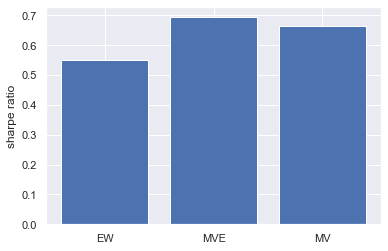

In [30]:
names=['EW','MVE','MV']
values=[SR_SMB_EW,SR_SMB_MVE,SR_SMB_MV]
plt.figure(figsize(6,4))
plt.bar(names,values)
plt.ylabel('sharpe ratio');

From the above graph, we found that the Mean-variance efficient method can give us the highest Sharpe Ratio, thus we choose this method to construct our final optimal portfolio. We show the optimal weight using bar chart.

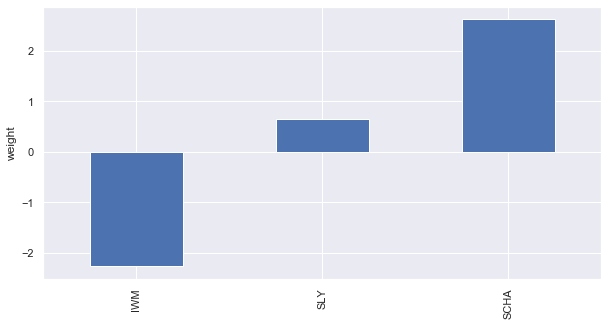

In [31]:
SMB_TARGET_W['SMB_MV'].plot(kind='bar',figsize=(10,5))
plt.ylabel('weight');

Apparently, we choose the MVE method because it has the highest SR.

## Thirdly, we talk about the Value factor (HML ETFs)

## Step3. Organize a data set on the returns of the HML ETFs

We run linear regression on HML factor.

In [32]:
RESULTS_HML, GRS = Time_Series_Regressions(HML, factors, HML.columns, '2010', '2019')
RESULTS_HML

,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
DIA,0.105170,0.138443,-0.018499,-1.596564,0.930602,180.844403,-0.248503,-26.154830,0.058633,6.208290,0.937999,0.759663,-0.535026
IWD,0.089510,0.144879,-0.027664,-3.519303,0.953280,273.068769,-0.071785,-11.136838,0.306761,47.878569,0.973944,0.617825,-1.179358
MDYV,0.084846,0.163253,-0.017176,-0.627044,0.867121,71.277567,0.333048,14.827200,0.271293,12.150722,0.750796,0.519717,-0.210129
MGV,0.095039,0.141532,-0.023782,-2.632676,0.944587,235.447885,-0.190234,-25.681494,0.260648,35.399441,0.963941,0.671503,-0.882239
PRFDX,0.046994,0.150711,-0.065563,-3.382688,0.924434,107.395997,-0.068017,-4.279632,0.332970,21.076940,0.853609,0.311818,-1.133576
RFV,0.089797,0.187459,-0.017200,-0.629608,0.977711,80.584080,0.540802,24.141040,0.509979,22.902419,0.812010,0.479021,-0.210989
RZV,0.083651,0.216123,-0.018587,-0.769613,1.021120,95.200232,1.112707,56.185053,0.631142,32.061079,0.889464,0.387055,-0.257906
VOE,0.097469,0.153003,-0.019989,-1.593282,0.960518,172.389181,0.137096,13.326265,0.244525,23.912124,0.940486,0.637041,-0.533927
VONV,0.090367,0.143826,-0.022085,-1.571796,0.917376,147.010527,-0.079183,-6.872428,0.309709,27.042351,0.915521,0.628308,-0.526726
VTV,0.100243,0.142982,-0.018675,-2.350579,0.952163,269.856053,-0.140258,-21.529229,0.270740,41.808315,0.972671,0.701087,-0.787705


We show the performance of these ETFs in during the selected time period.

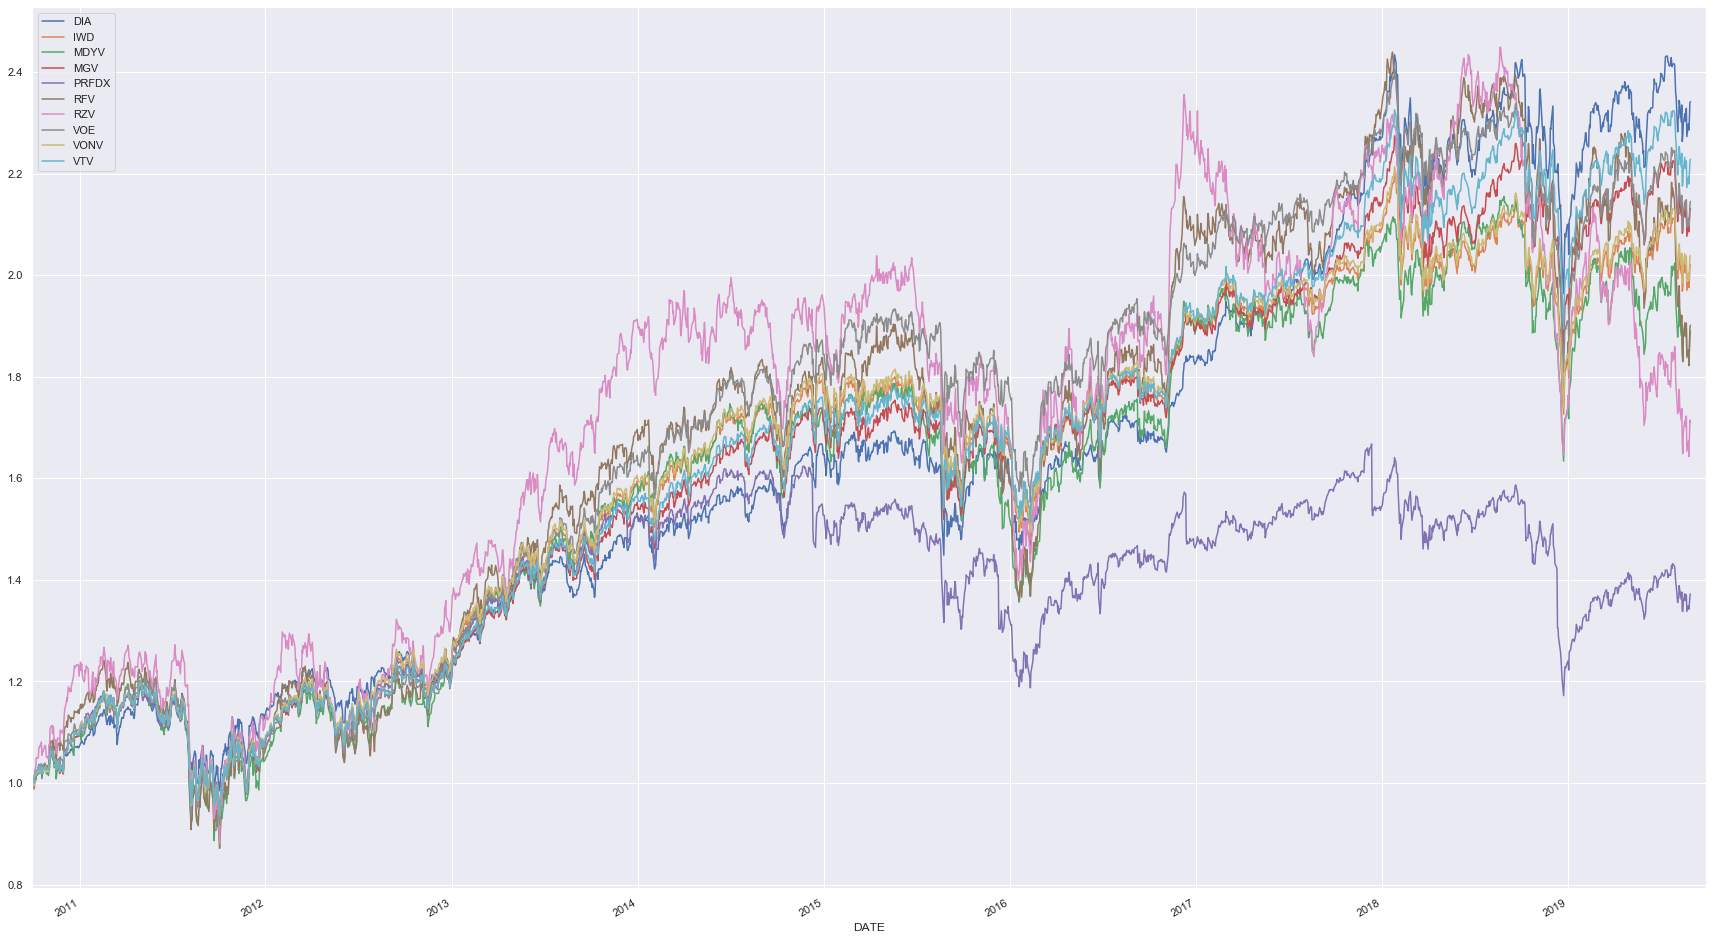

In [33]:
graph_HML = (1+HML).cumprod().plot(figsize = (30,18));
graph_HML.set_xlim([datetime.date(2010, 9, 30), datetime.date(2019, 9, 30)]);

## Step4. Factor by factor look at how well the HML ETFs implement the factors
## a. Focus on how well the ETF span exposure to the factor

The larger the beta is, the better the ETFs implement the factors

## b. And how cheaply it does, i.e., per unit of exposure to the factor, how much investors pay in terms of a negative alpha, and in terms of tracking error

In [34]:
cost_HML=RESULTS_HML['Alpha']
cost_HML.sort_values()

PRFDX   -0.065563
IWD     -0.027664
MGV     -0.023782
VONV    -0.022085
VOE     -0.019989
VTV     -0.018675
RZV     -0.018587
DIA     -0.018499
RFV     -0.017200
MDYV    -0.017176
Name: Alpha, dtype: float64

We analyse this question using the negative Alpha. We sort the Alpha of each ETF. The smaller the value is, the more the investors pay and the more expensive the ETF is.

## Step5. Come up with a way to rank these ETFs for each factor and explain your thinking behind the ranking

Part(1) We rank these ETFs based on the condition of R_Squared>0.7 and Sharpe Ratio>0 and sort them based on b_HML.

In [35]:
RESULTS_HML_RANK=RESULTS_HML[(RESULTS_HML.R_Squared>0.7) & (RESULTS_HML.SR>0)]
RESULTS_HML_RANK.sort_values('b_HML',inplace=True)
RESULTS_HML_RANK

,AvgReturns,Std,Alpha,t_Alpha,b_MKTRF,t_MKTRF,b_SMB,t_SMB,b_HML,t_HML,R_Squared,SR,AR
DIA,0.105170,0.138443,-0.018499,-1.596564,0.930602,180.844403,-0.248503,-26.154830,0.058633,6.208290,0.937999,0.759663,-0.535026
VOE,0.097469,0.153003,-0.019989,-1.593282,0.960518,172.389181,0.137096,13.326265,0.244525,23.912124,0.940486,0.637041,-0.533927
MGV,0.095039,0.141532,-0.023782,-2.632676,0.944587,235.447885,-0.190234,-25.681494,0.260648,35.399441,0.963941,0.671503,-0.882239
VTV,0.100243,0.142982,-0.018675,-2.350579,0.952163,269.856053,-0.140258,-21.529229,0.270740,41.808315,0.972671,0.701087,-0.787705
MDYV,0.084846,0.163253,-0.017176,-0.627044,0.867121,71.277567,0.333048,14.827200,0.271293,12.150722,0.750796,0.519717,-0.210129
IWD,0.089510,0.144879,-0.027664,-3.519303,0.953280,273.068769,-0.071785,-11.136838,0.306761,47.878569,0.973944,0.617825,-1.179358
VONV,0.090367,0.143826,-0.022085,-1.571796,0.917376,147.010527,-0.079183,-6.872428,0.309709,27.042351,0.915521,0.628308,-0.526726
PRFDX,0.046994,0.150711,-0.065563,-3.382688,0.924434,107.395997,-0.068017,-4.279632,0.332970,21.076940,0.853609,0.311818,-1.133576
RFV,0.089797,0.187459,-0.017200,-0.629608,0.977711,80.584080,0.540802,24.141040,0.509979,22.902419,0.812010,0.479021,-0.210989
RZV,0.083651,0.216123,-0.018587,-0.769613,1.021120,95.200232,1.112707,56.185053,0.631142,32.061079,0.889464,0.387055,-0.257906


Part(2) We select 3 target ETFs based on b_HML (from top to bottom).

In [36]:
HML_TARGET=HML[['RZV','RFV','PRFDX']]
HML_TARGET.head()

,RZV,RFV,PRFDX
DATE,,,
2010-10-01,0.006446,0.000994,0.005584
2010-10-04,-0.012533,-0.012711,-0.008819
2010-10-05,0.030612,0.022333,0.021038
2010-10-06,0.004792,-0.002328,-0.000010
2010-10-07,0.001782,-0.001669,-0.002759


## Step6. Once you have the top ranked ETF for each of your factors, explain how to construct the optimal portfolio among these ETFs. Explain your logic.

We construct these ETFs using 3 different weighting method.

Equal Weighted

In [37]:
EW=np.ones(3)/3
RE_HML_EW=(HML_TARGET@EW).mean()*252

STD_HML_EW=(EW.T@HML_TARGET.cov()@EW*252)**0.5

SR_HML_EW=(RE_HML_EW-RF)/STD_HML_EW
SR_HML_EW
print("The SR of Equal weighted is",SR_HML_EW)

The SR of Equal weighted is 0.3932102898703093


Mean-variance Efficient

In [38]:
#We determine the weight of these ETFs
HML_TARGET_Mean = HML_TARGET.mean()
HML_TARGET_Std = HML_TARGET.std()
HML_TARGET_Cov = HML_TARGET.cov()
HML_TARGET_W = pd.DataFrame([], index = HML_TARGET.columns)
HML_TARGET_W['HML_MVE'] = np.linalg.inv(HML_TARGET_Cov)@ HML_TARGET_Mean
HML_TARGET_W['HML_MVE'] = HML_TARGET_W['HML_MVE']/HML_TARGET_W['HML_MVE'].sum()
HML_TARGET_W['HML_MVE']

RZV     -0.227940
RFV      1.816504
PRFDX   -0.588565
Name: HML_MVE, dtype: float64

In [39]:
HML_W_MVE=HML_TARGET_W['HML_MVE']
RE_HML_MVE=(HML_TARGET@HML_W_MVE).mean()*252

STD_HML_MVE=(HML_W_MVE.T@HML_TARGET.cov()@HML_W_MVE*252)**0.5

SR_HML_MVE=(RE_HML_MVE-RF)/STD_HML_MVE
SR_HML_MVE
print("The SR of Mean-variance Efficient is",SR_HML_MVE)

The SR of Mean-variance Efficient is 0.4760243913359171


Minimun Variance

In [40]:
#We determine the weight of these ETFs
HML_TARGET_W['HML_MV'] = np.linalg.inv(HML_TARGET_Cov)@ np.ones(HML_TARGET_Mean.shape[0])
HML_TARGET_W['HML_MV'] = HML_TARGET_W['HML_MV']/HML_TARGET_W['HML_MV'].sum()
HML_TARGET_W['HML_MV']

RZV     -0.301809
RFV      0.243986
PRFDX    1.057823
Name: HML_MV, dtype: float64

In [41]:
HML_W_MV=HML_TARGET_W['HML_MV']
RE_HML_MV=(HML_TARGET@HML_W_MV).mean()*252

STD_HML_MV=(HML_W_MV.T@HML_TARGET.cov()@HML_W_MV*252)**0.5

SR_HML_MV=(RE_HML_MV-RF)/STD_HML_MV
SR_HML_MV
print("The SR of Minimun Variance is",SR_HML_MV)

The SR of Minimun Variance is 0.2802188183030167


We plot the Sharpe ratios of different allocation methods.

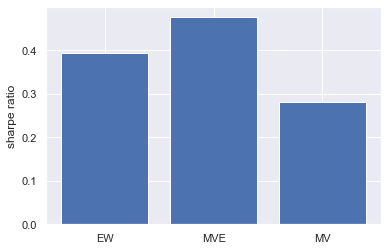

In [42]:
names=['EW','MVE','MV']
values=[SR_HML_EW,SR_HML_MVE,SR_HML_MV]
plt.figure(figsize(6,4))
plt.bar(names,values)
plt.ylabel('sharpe ratio');

From the above graph, we found that the Mean-variance efficient method can give us the highest Sharpe Ratio, thus we choose this method to construct our final optimal portfolio. We show the optimal weight using bar chart.

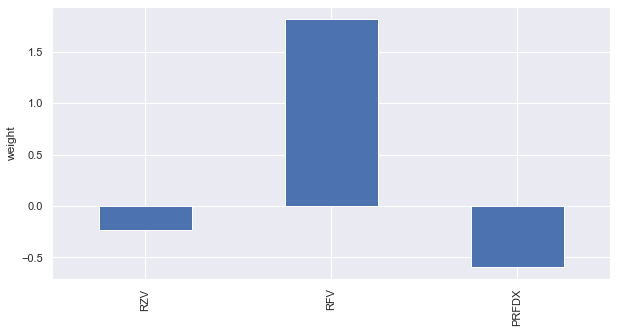

In [43]:
HML_TARGET_W['HML_MVE'].plot(kind='bar',figsize=(10,5))
plt.ylabel('weight');

Apparently, we choose the MVE method because it has the highest SR.

## * Construct our final optimal portfolio using the three previous seperate constructed optimal portfolios.

We construct the optimal portfolio using the weight of MVE for each factor and merge them together.

In [44]:
PORT_MKT=pd.DataFrame(MKT_TARGET@MKT_TARGET_W['MKT_MVE'],columns=['MKT'])
PORT_SMB=pd.DataFrame(SMB_TARGET@SMB_TARGET_W['SMB_MVE'],columns=['SMB'])
PORT_HML=pd.DataFrame(HML_TARGET@HML_TARGET_W['HML_MVE'],columns=['HML'])

PORT=pd.merge(PORT_MKT,PORT_SMB,on='DATE')
PORT=pd.merge(PORT,PORT_HML,on='DATE')
PORT.head()

,MKT,SMB,HML
DATE,,,
2010-10-01,-0.003462,0.001366,-0.002951
2010-10-04,-0.012986,-0.006332,-0.015042
2010-10-05,0.024098,0.014378,0.021208
2010-10-06,-0.012232,-0.015316,-0.005315
2010-10-07,0.002180,0.003656,-0.001815


We determine the weight of these sparate porfolios

In [45]:
PORT_Mean = PORT.mean()
PORT_Std = PORT.std()
PORT_Cov = PORT.cov()
PORT_W = pd.DataFrame([], index = PORT.columns)
PORT_W['PORT_MVE'] = np.linalg.inv(PORT_Cov)@ PORT_Mean
PORT_W['PORT_MVE'] = PORT_W['PORT_MVE']/PORT_W['PORT_MVE'].sum()
PORT_W['PORT_MVE']

MKT    0.763737
SMB    0.379439
HML   -0.143176
Name: PORT_MVE, dtype: float64

In [46]:
PORT_W_MVE=PORT_W['PORT_MVE']
RE_PORT_MVE=(PORT@PORT_W_MVE).mean()*252

STD_PORT_MVE=(PORT_W_MVE.T@PORT.cov()@PORT_W_MVE*252)**0.5

SR_PORT_MVE=(RE_PORT_MVE-RF)/STD_PORT_MVE
SR_PORT_MVE
print("The SR the final porfolio is",SR_PORT_MVE)

The SR the final porfolio is 0.9740297809106643


We show the optimal weight using bar chart.

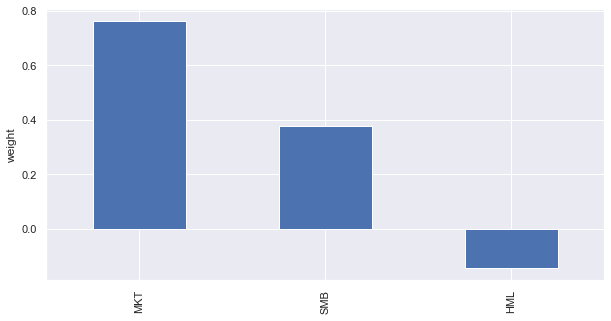

In [47]:
PORT_W['PORT_MVE'].plot(kind='bar',figsize=(10,5))
plt.ylabel('weight');

## Step7. Discuss how your allocation to the factors would be different if you could trade the factors directly instead of using the ETFs

## Trade factors directly

In [48]:
factors1=factors.copy()
factors1.drop('RF',axis='columns',inplace=True)
factors1.rename(columns={'MKTRF':'MKT'},inplace=True)
factors1.head()

,MKT,SMB,HML
DATE,,,
2010-09-30,-0.0026,0.0004,0.0030
2010-10-01,0.0043,-0.0006,0.0021
2010-10-04,-0.0088,-0.0072,-0.0007
2010-10-05,0.0211,0.0077,0.0014
2010-10-06,-0.0010,-0.0039,0.0047


In [49]:
#We determine the weight of these sparate porfolios
factors1_Mean = factors1.mean()
factors1_Std = factors1.std()
factors1_Cov = factors1.cov()
factors1_W = pd.DataFrame([], index = factors1.columns)
factors1_W['FACTOR_MVE'] = np.linalg.inv(factors1_Cov)@factors1_Mean
factors1_W['FACTOR_MVE'] = factors1_W['FACTOR_MVE']/factors1_W['FACTOR_MVE'].sum()
factors1_W['FACTOR_MVE']

MKT   -1.363417
SMB    1.232908
HML    1.130510
Name: FACTOR_MVE, dtype: float64

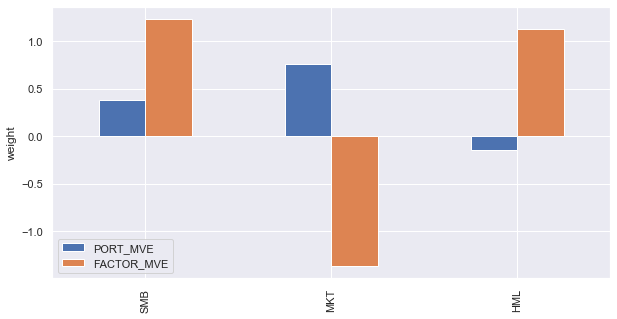

In [50]:
W_PORT=pd.DataFrame(PORT_W_MVE,index={'MKT','SMB','HML'})
W=W_PORT.merge(factors1_W['FACTOR_MVE'],left_index=True,right_index=True)
W.plot(kind='bar',figsize=(10,5))
plt.ylabel('weight');

If we trade the three factors directly, we found that the results were different. Our portfolio emphasized on the market factor, while trading factors directly emphasized on the size and value factor. We believe the emphasis on the market factor will perform better because the market factor is easier to track. Therefore, we believe our portfolio will outperform trading factors directly.

## Step8. Discuss which factor can be implemented more cheaply using the ETFs

In [51]:
cost_MKT_AVE=cost_MKT.mean()
print("The mean of cost_MKT is",cost_MKT_AVE)

The mean of cost_MKT is -0.016417021216356367


In [52]:
cost_SMB_AVE=cost_SMB.mean()
print("The mean of cost_SMB is",cost_SMB_AVE)

The mean of cost_SMB is -0.0570527590244824


In [53]:
cost_HML_AVE=cost_HML.mean()
print("The mean of cost_HML is",cost_HML_AVE)

The mean of cost_HML is -0.024922251398612365


The market factor (MKT) can be implemented more cheaply using its ETFs compared with other factors, since the average Alpha of the ETFS under the market factor is larger.